In this case study, we will implement hierarchical risk parity based on clustering
methods and compare it against other portfolio allocation methods. The case study is based on the paper _“Building Diversified Portfolios that Outperform Out-ofSample” (2016) by Marcos Lopez de Prado._ 



## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Building Hierarchy Graph/ Dendogramg](#4.1)
    * [5.2. Steps for Hierarchial Risk Parity](#4.2)
* [6.Backtesting-Out Of Sample ](#5)  

<a id='0'></a>
# 1. Problem Definition

The main idea of the risk parity strategy is that all assets in the portfolio contribute in the same proportion to the risk of the portfolio. That is, depending on their own risk, the weight in the portfolio is set [1].

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

Checking is the additional packages needed are present, if not install them. Let us chek is the cvxopt package is present, if not install it. This package is checked separately as it is not included in requirement.txt of this book repository.

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
# load dataset
dataset = read_csv('SP500Data_2018.csv',index_col=0)

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(251, 502)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
02/01/2018,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
03/01/2018,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
04/01/2018,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
05/01/2018,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
08/01/2018,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


<a id='2.2'></a>
## 3.2. Data Visualization

We will look at the data visualisation in the later sections.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(251, 502)

Getting rid of the columns with more than 30% missing values. 

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(251, 498)

Given that there are null values drop the rown contianing the null values.

In [10]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
02/01/2018,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
03/01/2018,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


<a id='3.2'></a>
## 4.2. Data Transformation

For the purpose of clustering, we will be using annual
returns. Additionally, we will train the data followed by testing. Let us prepare the
dataset for training and testing, by separating 20% of the dataset for testing followed
by generating the return series.

In [11]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [12]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [13]:
#Calculate percentage return for the training data set
returns = X_train.pct_change().dropna()

In [14]:
#Question: Calculate percentage return for the test data set
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Building Hierarchy Graph/ Dendogram

The first step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Compute Correlation

In [15]:
# Question: compute a correlation-distance matrix by an correlation matrix
# Hint: you can find this equation in the HRP slides
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [16]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([24.        , 25.        ,  0.14742158,  2.        ])

In [17]:
# Question: try different distance measurements, such as complete, average. 
# More choices can be found: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

link_complete = linkage(dist, 'complete')
link_average = linkage(dist, 'average')

Computation of linkages is followed by
the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root is the final single cluster. The “distance” between each cluster is shown on the y-axis, and thus the longer the branches
are, the less correlated two clusters are.

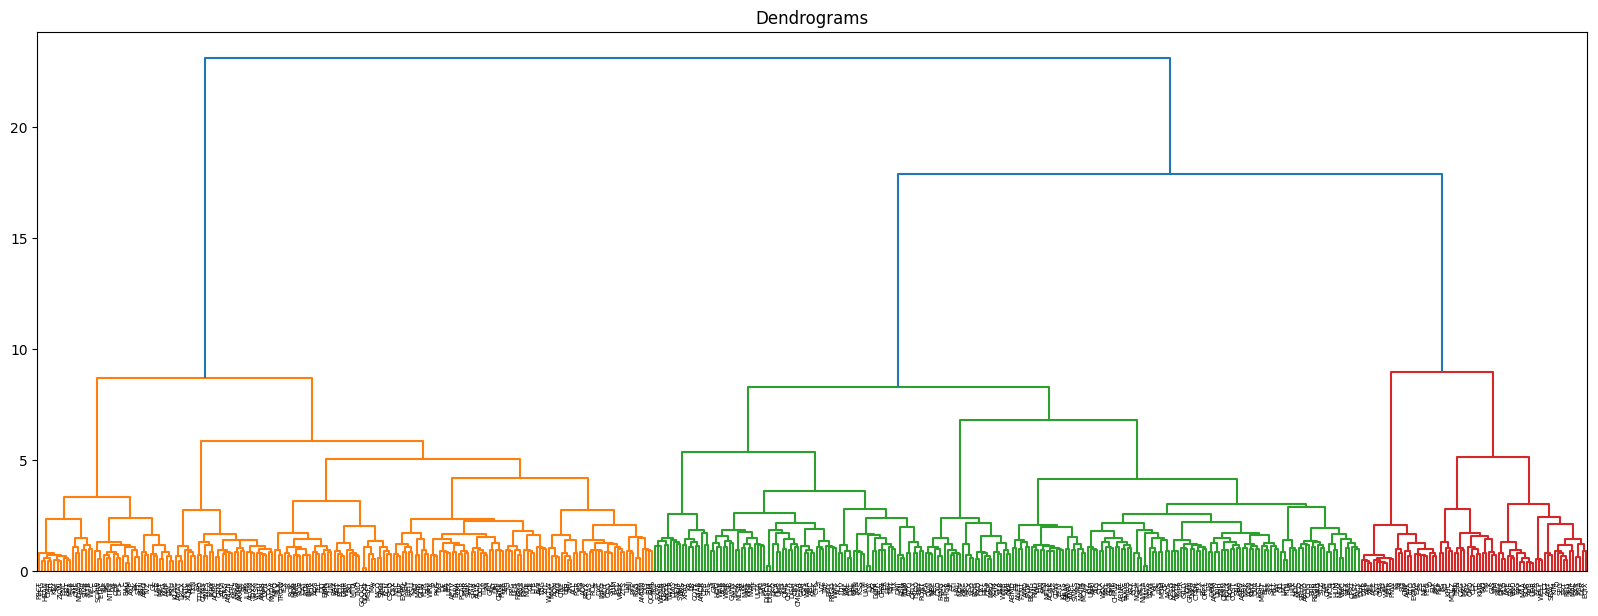

In [18]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link,labels = X.columns)
plt.show()

<a id='4.2'></a>
## 5.2 Steps for Hierarchial Risk Parity

#### Quasi-diagonalization and getting the weights for Hierarchial Risk Parity


A 'quasi-diagonalization' is a process usually known as matrix seriation and which can be performed using hierarchical clustering.
This process reorganize the covariance matrix so similar investments will be placed together. This matrix diagonalization allow us to distribute weights optimally following an inverse-variance allocation.

In [27]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx._append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive bisection

 This step distributes the allocation through recursive bisection based on cluster covariance.

In [28]:
def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    
    # Question: Compute variance per cluster: you can find this equation in the slides related to the recursive bisection
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [29]:
# Question: Compute the inverse-variance portfolio: this equation can be found in the slides about recursive bisection
def getIVP(cov, **kargs): 
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [30]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Step 4:  Getting the portfolio weights for all types of asset allocation

In [31]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    portfolios = pd.DataFrame([hrp], index=['HRP']).T
    return portfolios

In [32]:
portfolios = get_all_portfolios(returns)

Text(0.5, 1.0, 'HRP')

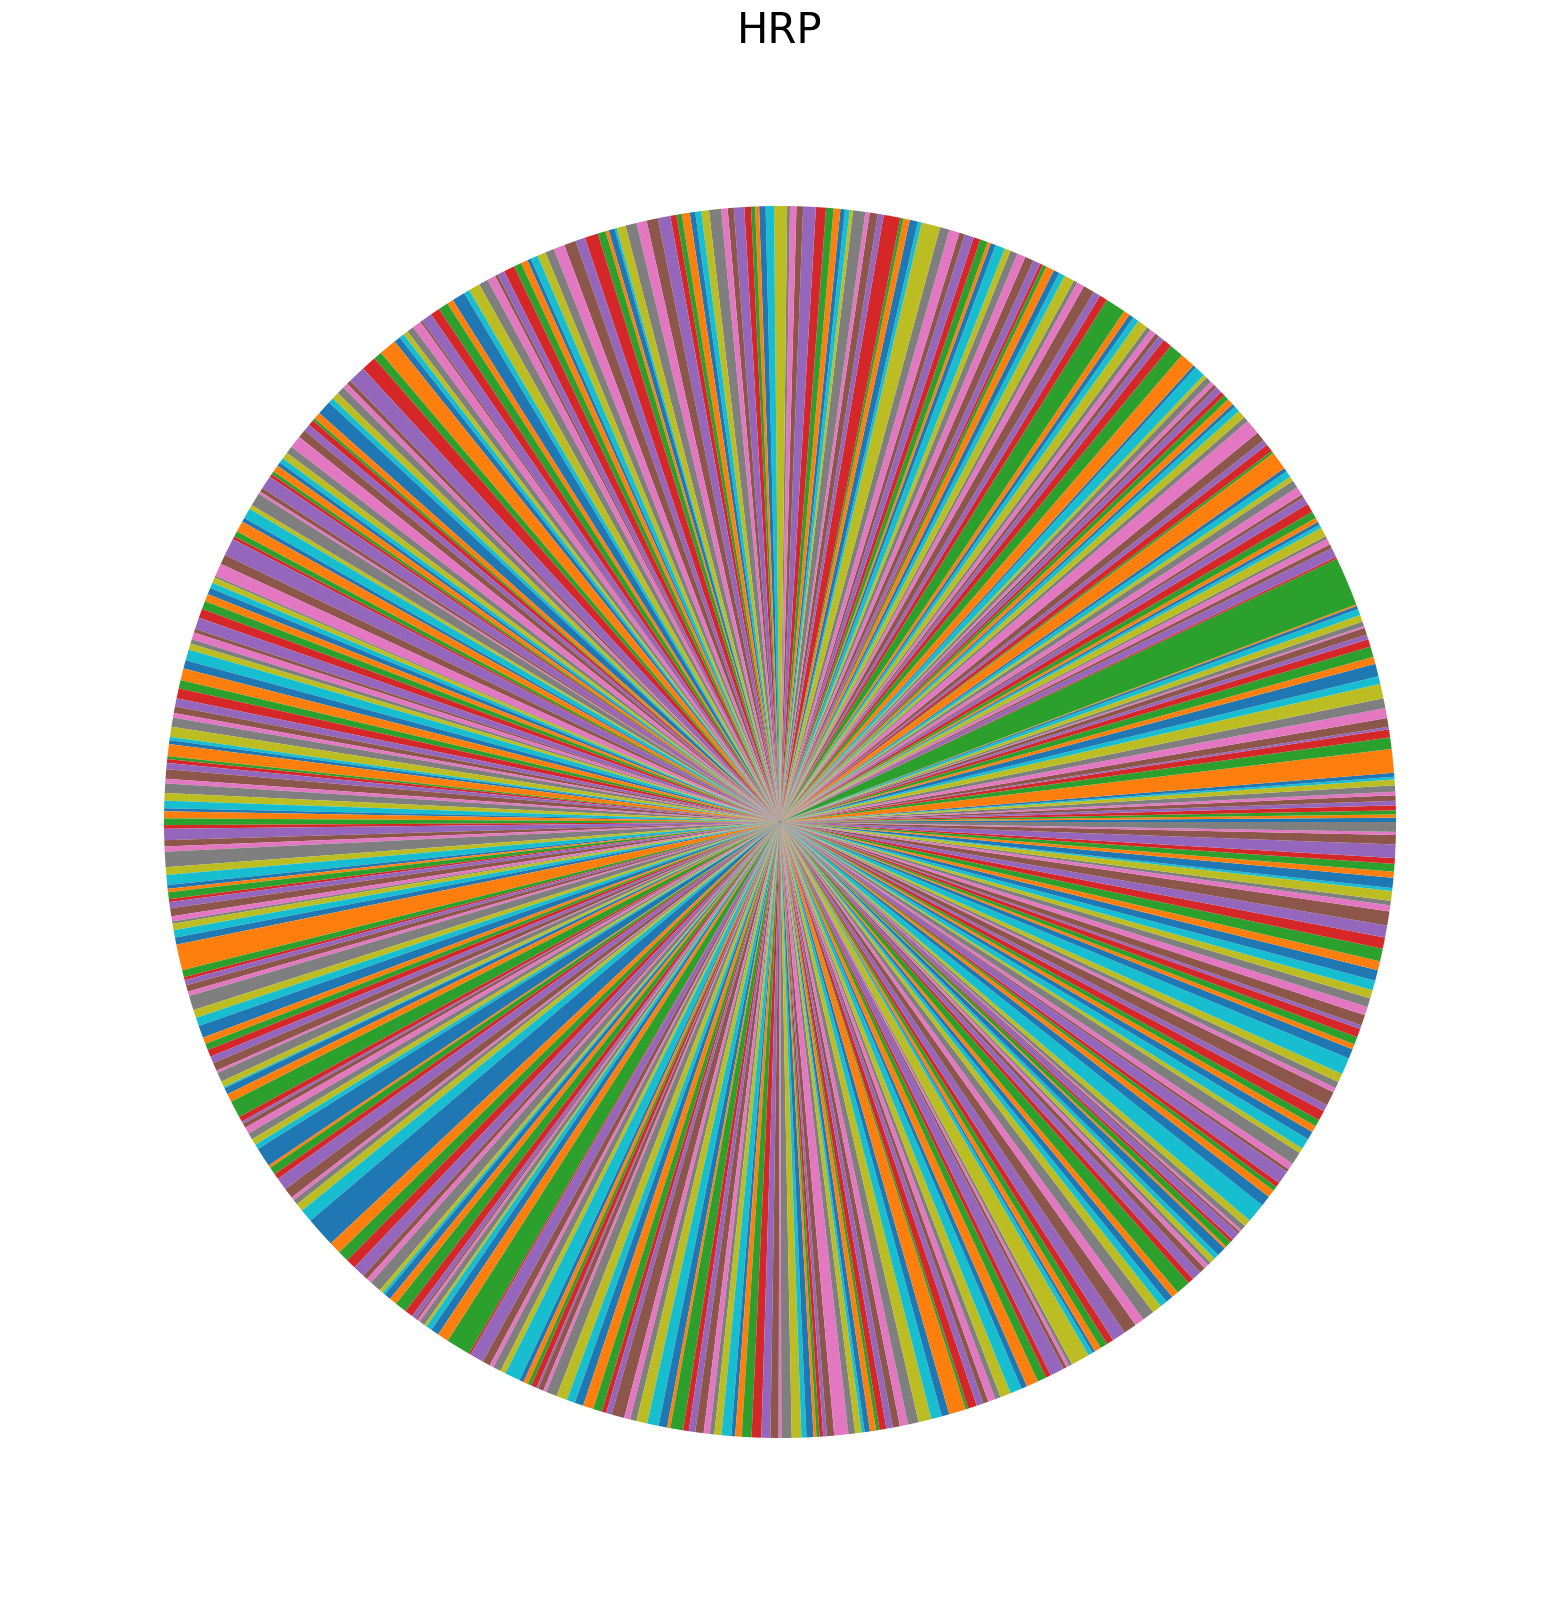

In [33]:
fig, (ax1) = plt.subplots(1, 1,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0]);
ax1.set_title('HRP',fontsize = 30)

The first pie chart shown the asset allocation of HRP. We clearly see more diversification in HRP.

<a id='5'></a>
# 6. Backtesting-Out Of Sample 

In [34]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['HRP'], index = returns_test.index)

<Axes: title={'center': 'Out Of Sample Results'}, xlabel='Date'>

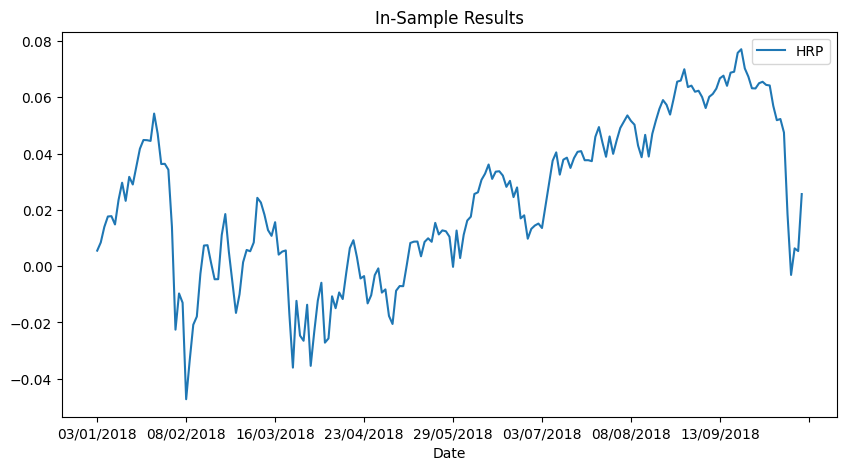

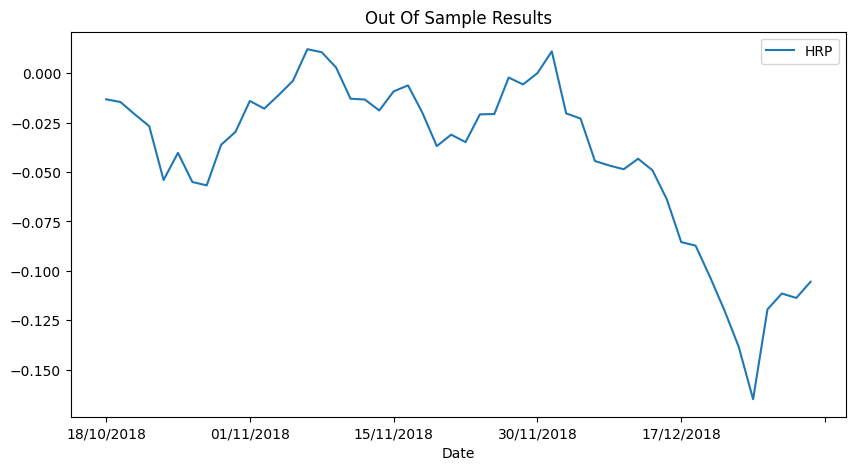

In [35]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

### In Sample and Out of Sample Results

In [36]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
HRP,0.134705,0.240707


In [37]:
# Question: Inspired by the above in-sample process, please complete out-of-sample results.

stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
HRP,0.226123,-2.352784


**Conclusion**

In the hierarchical clustering-based allocation, the allocation is more diverse and distributed across many assets. These portfolios then offer better tail risk management.

Finally, we looked at the backtesting framework, which enables us to compute and
analyze the in-sample and out of sample return and sharpe ratio of each hypothetical
portfolio. This helps in determining the best performer out of all the portfolio allocation methods. The hierarchical clustering approaches yielded the best out-of-sample
results.


References:
[1] https://quantdare.com/risk-parity-versus-inverse-volatility/


# Clustering individuals for Portfolio Management

Please note that this case study is *optional* to study. Source from - Tatsat, Hariom, Sahil Puri, and Brad Lookabaugh. Machine Learning and Data Science Blueprints for Finance. O'Reilly media, 2020.

We learned how to leverage hierarchical clustering for portfolio management. In this case study, we will use other clustering methods learned from the unit Introduction to Artificial Intelligence and Data Analytics to indicate portfolio management by identifying different types of investors. Given, the clustering algorithms can successfully group investors based on different factors, such as age, income, and risk tolerance, it can further used by portfolio managers to understand the investor’s behavior and standardize the portfolio allocation and rebalancing across the clusters, making the investment management process faster and effective.

<a id='0'></a>
# 1. Problem Definition

The goal of this case study is to build a machine learning model to cluster individuals/investors based on the parameters related to the ability and willingness to take risk. We will focus on using common demographic and financial characteristics to accomplish this.

For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve Board, which has been used in the case studies in chapter 5 and chapter 6. 

In [44]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Loading the Data

The dataset is same as the dataset used, which is further processed to give the following attributes for different investors for the year 2007.

In [45]:
# load dataset
dataset = pd.read_excel('FRB_data.xlsx')

In [46]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [47]:
# shape
dataset.shape

(3866, 13)

In [48]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,1,3,2,1,0,2,1,3,1,1,5,3,4
1,2,4,4,1,2,5,2,3,0,2,5,5,5
2,3,3,1,1,2,3,2,2,1,2,4,4,4
3,4,3,1,1,2,3,2,2,1,2,4,3,4
4,5,4,3,1,1,5,1,2,1,3,3,5,5


As we can see in the table above, there are 12 attributes for each of the individuals. These attributes can be categorized as demographic, financial and behavioral attributes. 

In [51]:
# describe data
dataset.describe()

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
count,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000
mean,1933.500000,3.107346,2.906363,1.353337,0.937662,3.696844,1.741593,3.042938,0.716503,2.445939,3.561045,2.976203,3.671495
std,1116.162399,1.512556,1.066253,0.478068,1.249059,1.617554,0.934443,0.879385,0.450754,0.743267,1.304197,1.462937,1.183631
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,967.250000,2.000000,2.000000,1.000000,0.000000,3.000000,1.000000,2.000000,0.000000,2.000000,2.000000,2.000000,3.000000
50%,1933.500000,3.000000,3.000000,1.000000,0.000000,3.000000,1.000000,3.000000,1.000000,3.000000,4.000000,3.000000,4.000000
75%,2899.750000,4.000000,4.000000,2.000000,2.000000,5.000000,3.000000,4.000000,1.000000,3.000000,5.000000,4.000000,5.000000
max,3866.000000,6.000000,4.000000,2.000000,8.000000,6.000000,4.000000,4.000000,1.000000,3.000000,5.000000,5.000000,5.000000


<a id='2.2'></a>
## 3.2. Data Visualization

Let us look at the correlation. We will take a detailed look into the visualization post clustering.

<Axes: title={'center': 'Correlation Matrix'}>

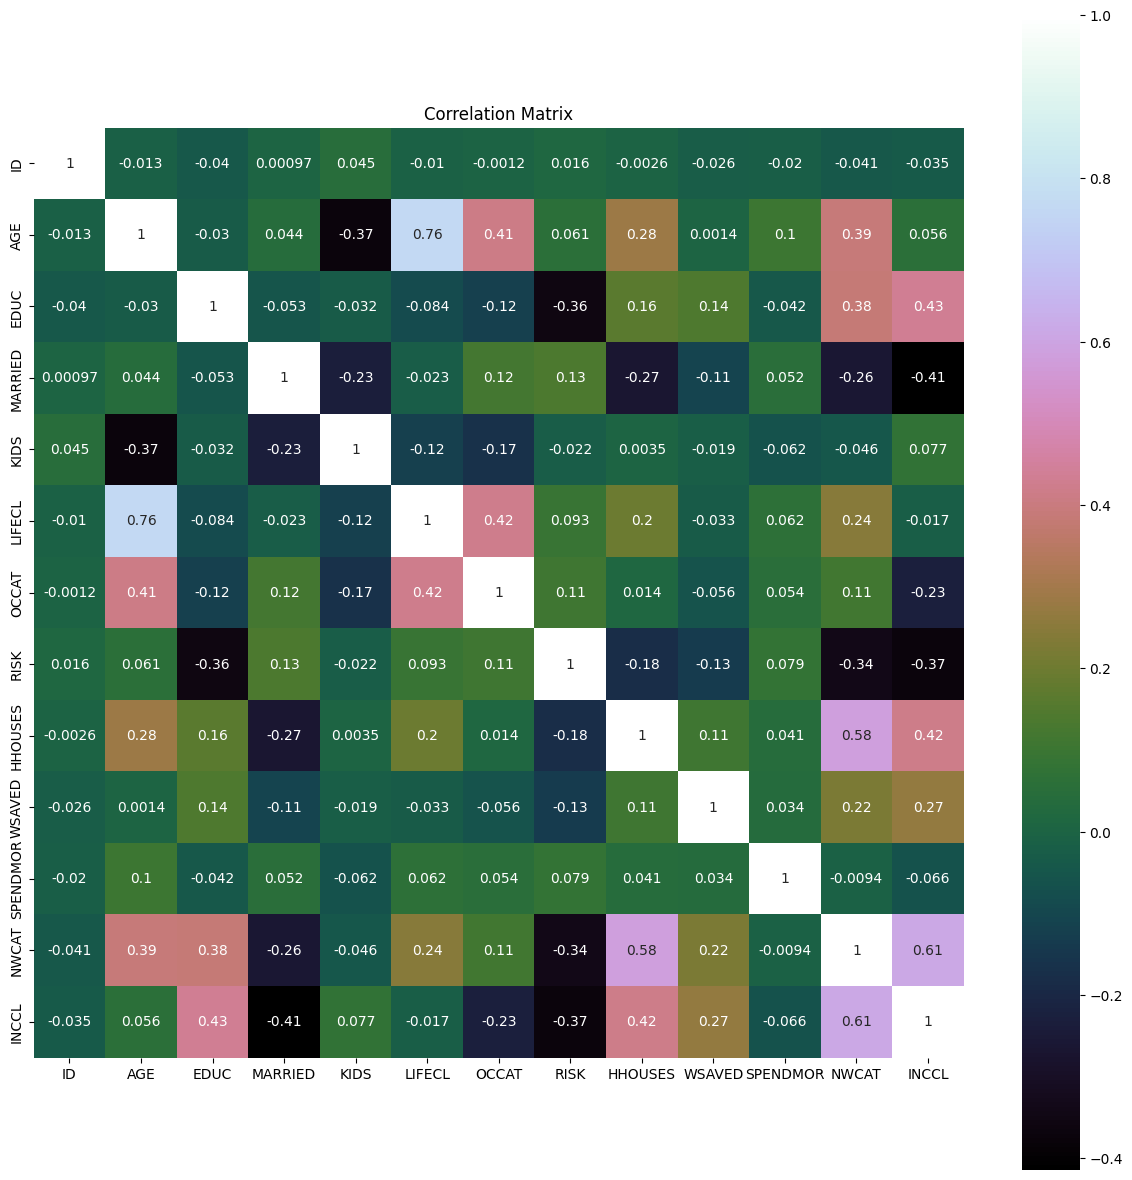

In [52]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

As it can be seen by the picture above there is a significant positive correlation between the stocks.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [53]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given there isn't any missing data and the data is already in the categorical format no further data cleaning was performed. The ID column which is not needed is dropeed

In [54]:
X=dataset.copy("deep")
X=X.drop(['ID'], axis=1)
X.head()

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,3,2,1,0,2,1,3,1,1,5,3,4
1,4,4,1,2,5,2,3,0,2,5,5,5
2,3,1,1,2,3,2,2,1,2,4,4,4
3,3,1,1,2,3,2,2,1,2,4,3,4
4,4,3,1,1,5,1,2,1,3,3,5,5


<a id='3.2'></a>
## 4.2. Data Transformation

The data available is comprised of attributes with similar scale. Hence no data transformation is required. 

<a id='4'></a>
# 5. Evaluate Algorithms and Models

In this step, we will look at the following models and perform further analysis and visualization.

1. K-means
2. Affinity Propagation


<a id='5.1'></a>
## 5.1. K-Means Clustering


In this step we look at the following metrices to get the optimum number of clusters

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

Typically, two metrics are used to evaluate the number of clusters in K-means model.

1. Sum of square errors (SSE) within clusters
2. Silhouette score


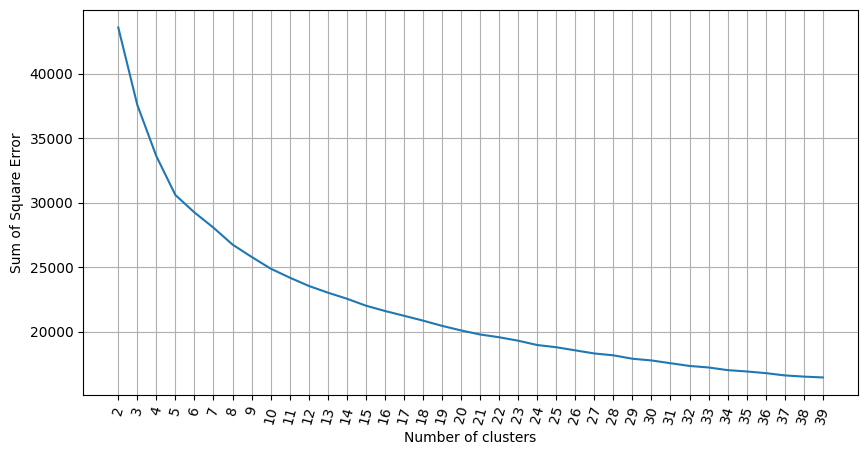

In [58]:
distorsions = []
max_loop=40
for k in range(2, max_loop):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Square Error")
plt.grid(True)

#### Silhouette score

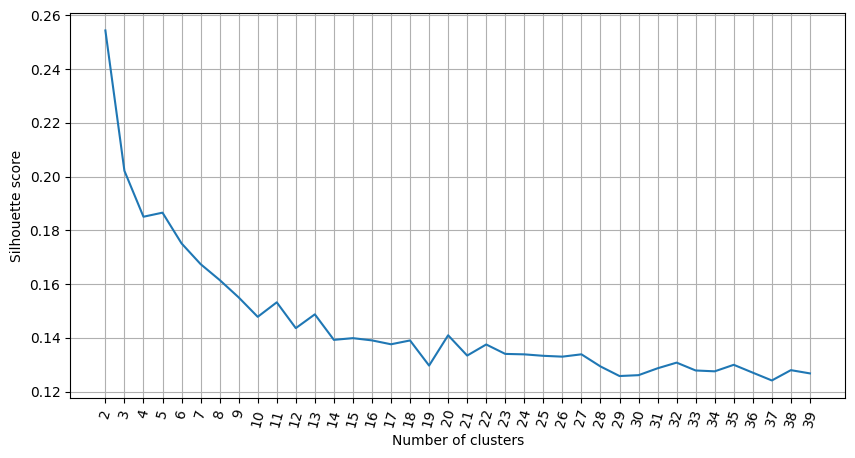

In [79]:
# Question: Inspired by the usage of SSE for finding the optimal number of clusters, 
# can you use another evaluation Silhouette score for this task? 
# Hint: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)

Looking at both the charts above, the optimum number of clusters seem to be around 7. We can see that as the number of clusters increase pass 6, the sum of square of
errors within clusters plateaus off. From the second graph, we can see that there are
various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 7 clusters, we would use 7 clusters in the k-means model below.

<a id='5.1.2'></a>
### 5.1.2. Clustering and Visualisation

In [62]:
nclust=7

In [63]:
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=7)

In [65]:
#Extracting labels 
target_labels = k_means.predict(X)

<a id='5.2'></a>
## 5.2. Affinity Propagation

In [66]:
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X)

In [67]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 161


<a id='5.3'></a>
## 5.3. Cluster Evaluation

We evaluate the clusters using Silhouette Coefficient (sklearn.metrics.silhouette_score). Higher Silhouette Coefficient score means a model with better defined clusters. 

In [68]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.17142299800840569
ap 0.0972589700251017


k-means has much higher Silhouette Coefficient as compared to the affinity propagation. 

<a id='6'></a>
# 6. Cluster Intuition
In the next step, we will check each cluster and understand the intuition behind the clusters. 

In [70]:
cluster_output= pd.concat([pd.DataFrame(X), pd.DataFrame(k_means.labels_, columns = ['cluster'])],axis = 1)
output=cluster_output.groupby('cluster').mean()
output

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
cluster,,,,,,,,,,,,
0,1.977778,2.538272,1.249383,1.977778,3.281481,1.397531,3.204938,0.572840,2.246914,1.851852,1.916049,3.407407
1,2.334737,3.391579,1.362105,0.138947,1.776842,1.326316,2.707368,0.858947,2.623158,3.730526,3.532632,4.343158
2,2.515539,3.592322,1.100548,2.285192,3.144424,1.477148,2.506399,0.952468,2.691042,3.533821,4.285192,4.718464
3,4.665826,3.457755,1.225725,0.298865,5.350567,2.076923,2.745271,0.941992,2.624212,3.551072,4.514502,4.505675
4,4.837349,2.159639,1.578313,0.188253,5.620482,2.368976,3.552711,0.709337,2.269578,3.900602,2.361446,2.674699
5,1.885397,2.341959,1.353050,2.114603,3.371534,1.443623,3.415896,0.478743,2.208872,4.406654,1.670980,3.014787
6,1.802721,2.696145,1.643991,0.004535,1.360544,1.650794,3.231293,0.299320,2.369615,3.451247,1.487528,2.698413


### Demographics Features

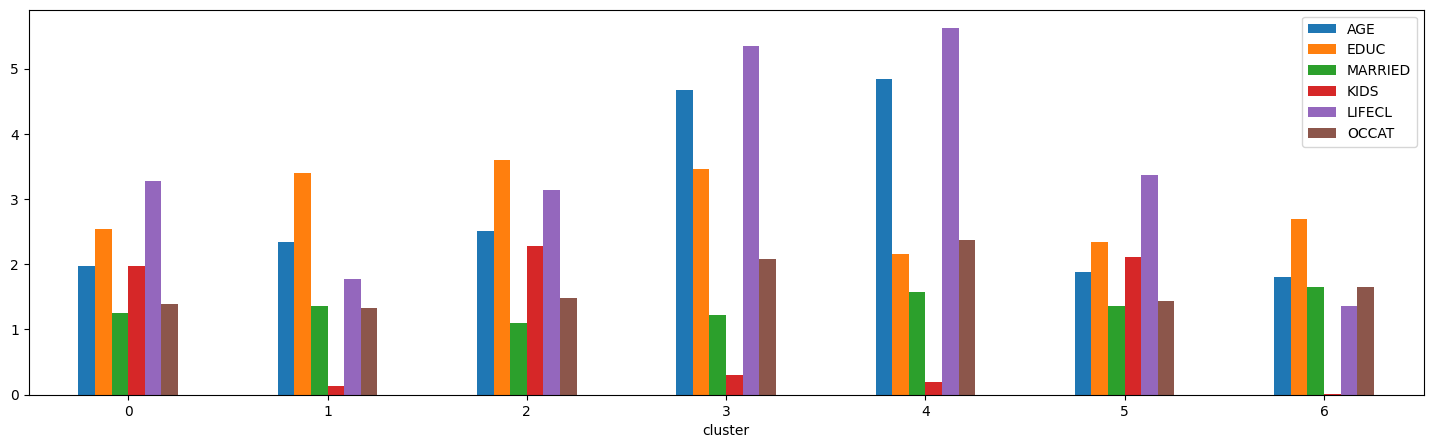

In [71]:
output[['AGE','EDUC','MARRIED','KIDS','LIFECL','OCCAT']].plot.bar(rot=0, figsize=(18,5));

Question: What are your observations from the above shown bar chart?

The plot here shows the average value of the attributes for each of the clusters. For
example, comparing cluster 0 and cluster 1, cluster 0 has lower average age, yet higher
average education. In terms of marriage and number of children, these two clusters
are similar. So, the individuals in cluster 0 will on an average have higher risk toler‐
ance as compared to the individuals in cluster 1, based on the demographic attributes.

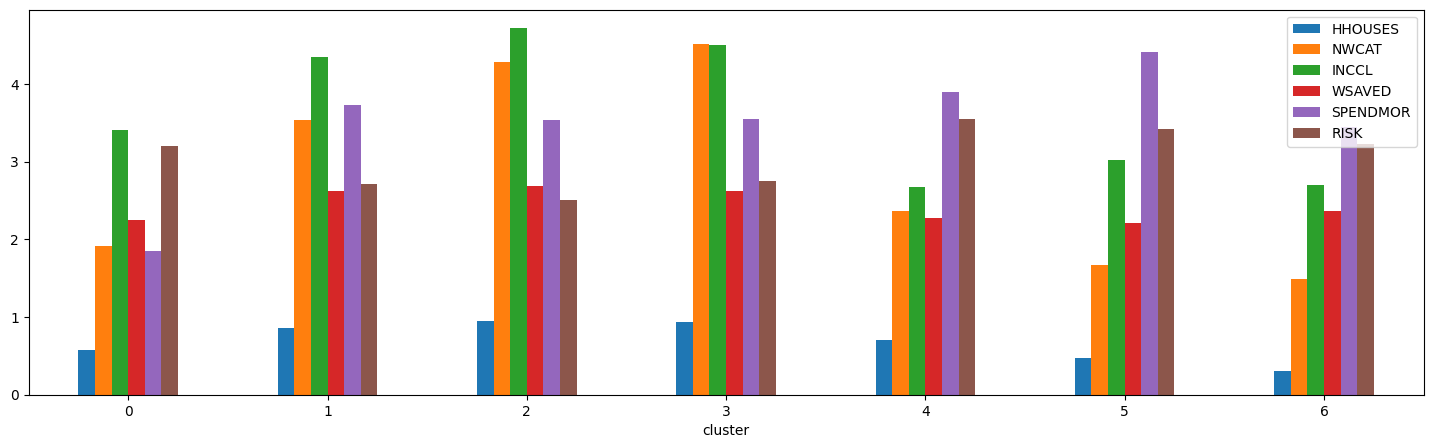

In [80]:
# Question: Can you visualise the rest of the features ('HHOUSES','NWCAT','INCCL','WSAVED','SPENDMOR','RISK') as bar charts? 


output[['HHOUSES','NWCAT','INCCL','WSAVED','SPENDMOR','RISK']].plot.bar(rot=0, figsize=(18,5));

<Axes: xlabel='cluster'>

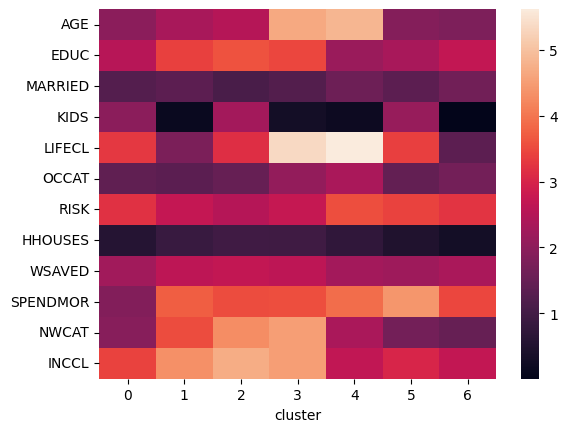

In [73]:
sns.heatmap(output.T)

Combining the information from the demographics, financial, and behavioral
attributes for cluster 0 and cluster 1, the overall ability to take risk for individual clus‐
ter 0 is higher as compared to cluster 1. Performing similar analysis across all other
clusters, we summarize the results in the table below. The risk tolerance column rep‐
resents the subjective assessment of the risk tolerance of each of the clusters.

| Cluster| Features | Risk Capacity |
| --- | --- | --- |
| Cluster 0	 | Low Age, High Networth and Income, Less risky life category, willingness to spend more | High |
| Cluster 1	 | High Age, low net worth and Income, highly risky life category, Willing ness to take risk, low education | High |
| Cluster 2	 | High Age, high net worth and Income, highly risky life category, Willing ness to to take risk, own house | Medium |
| Cluster 3	 | 	Low age, very low income and net worth, high willingness to take risk, many kids | Low |
| Cluster 4	 | Medium age, very high income and net worth, high willingness to take risk, many kids, own house | High |
| Cluster 5	 | Low age, very low income and net worth, high willingness to take risk, no kids | Medium |
| Cluster 6	 | Low age, medium income and net worth, high willingness to take risk, many kids, own house | Low |
